In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
# Set TensorFlow to use v1 behavior which is required for DSO
tf.compat.v1.disable_v2_behavior()
global_sess = tf.compat.v1.Session()
tf.compat.v1.keras.backend.set_session(global_sess)
import tensorflow as tf
import types
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# Monkey patch the __array__ method in TensorFlow's Tensor class
def safe_array(self):
    try:
        return self.numpy()
    except:
        # Return a dummy array of the right shape
        shape = [dim.value for dim in self.shape]
        return np.zeros(shape or [1])

# Apply the monkey patch
tf.Tensor.__array__ = safe_array


In [38]:
# Create a global session that will be kept open throughout the script
global_sess = tf.compat.v1.Session()
tf.compat.v1.keras.backend.set_session(global_sess)

# Load Weather Dataset (Synthetic Example)
dates = pd.date_range(start="2023-01-01", periods=1000, freq="H")
temperature = 15 + 10 * np.sin(np.linspace(0, 20, 1000)) + np.random.normal(0, 1, 1000)
humidity = 60 + 5 * np.sin(np.linspace(0, 20, 1000)) + np.random.normal(0, 2, 1000)
pressure = 1013 + 3 * np.cos(np.linspace(0, 20, 1000)) + np.random.normal(0, 1, 1000)

df = pd.DataFrame({"Date": dates, "Temperature": temperature, "Humidity": humidity, "Pressure": pressure})
df.set_index("Date", inplace=True)


In [39]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # Predicting temperature
    return np.array(sequences), np.array(targets)

seq_length = 24
X, y = create_sequences(df_scaled, seq_length)

# Reshape y to ensure it's a 2D array
if len(y.shape) == 1:
    y = y.reshape(-1, 1)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define Static Batch Size for LSTM Compatibility
BATCH_SIZE = 32  # Can be adjusted based on data size

# Initialize variables
global_sess.run(tf.compat.v1.global_variables_initializer())

c:\Users\Gowtham Pandian\.conda\envs\DSO\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return reduction(axis=axis, dtype=dtype, out=out, **passkwargs)


Train on 780 samples, validate on 196 samples
Epoch 1/20
780/780 [==============================] - 2s 2ms/sample - loss: 0.0877 - val_loss: 0.0138
Epoch 2/20
780/780 [==============================] - 0s 576us/sample - loss: 0.0145 - val_loss: 0.0048
Epoch 3/20
780/780 [==============================] - 0s 552us/sample - loss: 0.0088 - val_loss: 0.0030
Epoch 4/20
780/780 [==============================] - 0s 588us/sample - loss: 0.0067 - val_loss: 0.0022
Epoch 5/20
780/780 [==============================] - 0s 573us/sample - loss: 0.0058 - val_loss: 0.0019
Epoch 6/20
780/780 [==============================] - 0s 577us/sample - loss: 0.0055 - val_loss: 0.0023
Epoch 7/20
780/780 [==============================] - 0s 575us/sample - loss: 0.0044 - val_loss: 0.0019
Epoch 8/20
780/780 [==============================] - 0s 568us/sample - loss: 0.0044 - val_loss: 0.0026
Epoch 9/20
780/780 [==============================] - 0s 575us/sample - loss: 0.0050 - val_loss: 0.0021
Epoch 10/20
780/780 

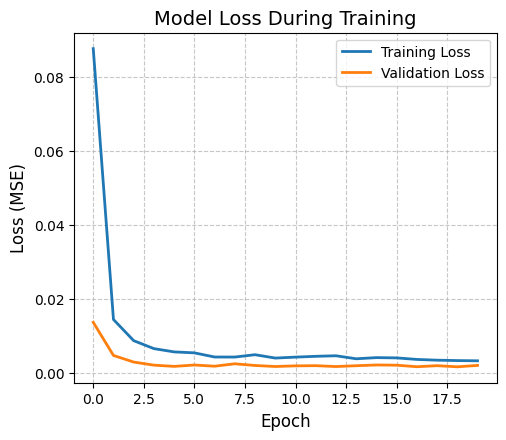

In [40]:
# Build and train LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(y_train.shape[1])  # Ensure correct output shape
])

# Compile Model
model.compile(optimizer="adam", loss="mse")

# Train Model
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=20, 
                    validation_data=(X_test, y_test), verbose=1)

# Predict using trained model
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)

# Inverse Transform Predictions to Original Scale
# Create full-sized arrays for inverse transform
y_test_full = np.zeros((y_test.shape[0], df.shape[1]))
y_test_full[:, 0] = y_test.flatten()

y_pred_full = np.zeros((y_pred.shape[0], df.shape[1]))
y_pred_full[:, 0] = y_pred.flatten()

y_test_actual = scaler.inverse_transform(y_test_full)[:, 0]
y_pred_actual = scaler.inverse_transform(y_pred_full)[:, 0]

# Create a directory for saving plots
os.makedirs('plots', exist_ok=True)

# Plot the training and validation loss
plt.figure(figsize=(12, 10))

# Plot 1: Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

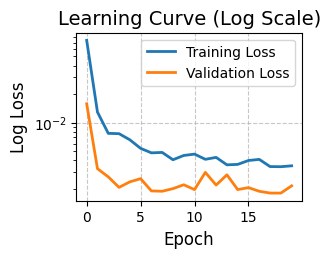

In [31]:
# Plot 2: Learning Curve (log scale)
plt.subplot(2, 2, 2)
plt.semilogy(history.history['loss'], label='Training Loss', linewidth=2)
plt.semilogy(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Learning Curve (Log Scale)', fontsize=14)
plt.ylabel('Log Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

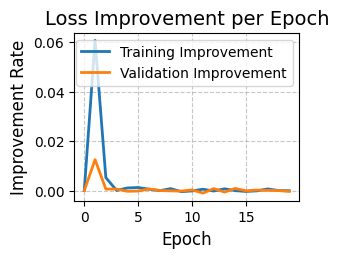

In [34]:
# Plot 3: Loss Improvement Rate
plt.subplot(2, 2, 3)
train_improvement = [0] + [history.history['loss'][i-1] - history.history['loss'][i] 
                          for i in range(1, len(history.history['loss']))]
val_improvement = [0] + [history.history['val_loss'][i-1] - history.history['val_loss'][i] 
                        for i in range(1, len(history.history['val_loss']))]
plt.plot(train_improvement, label='Training Improvement', linewidth=2)
plt.plot(val_improvement, label='Validation Improvement', linewidth=2)
plt.title('Loss Improvement per Epoch', fontsize=14)
plt.ylabel('Improvement Rate', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

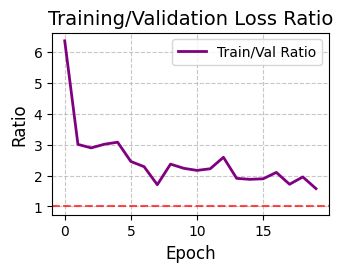

In [41]:
# Plot 4: Training vs Validation Loss Ratio
plt.subplot(2, 2, 4)
loss_ratio = [t/v if v != 0 else 1 for t, v in zip(history.history['loss'], history.history['val_loss'])]
plt.plot(loss_ratio, label='Train/Val Ratio', color='purple', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7)
plt.title('Training/Validation Loss Ratio', fontsize=14)
plt.ylabel('Ratio', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('plots/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

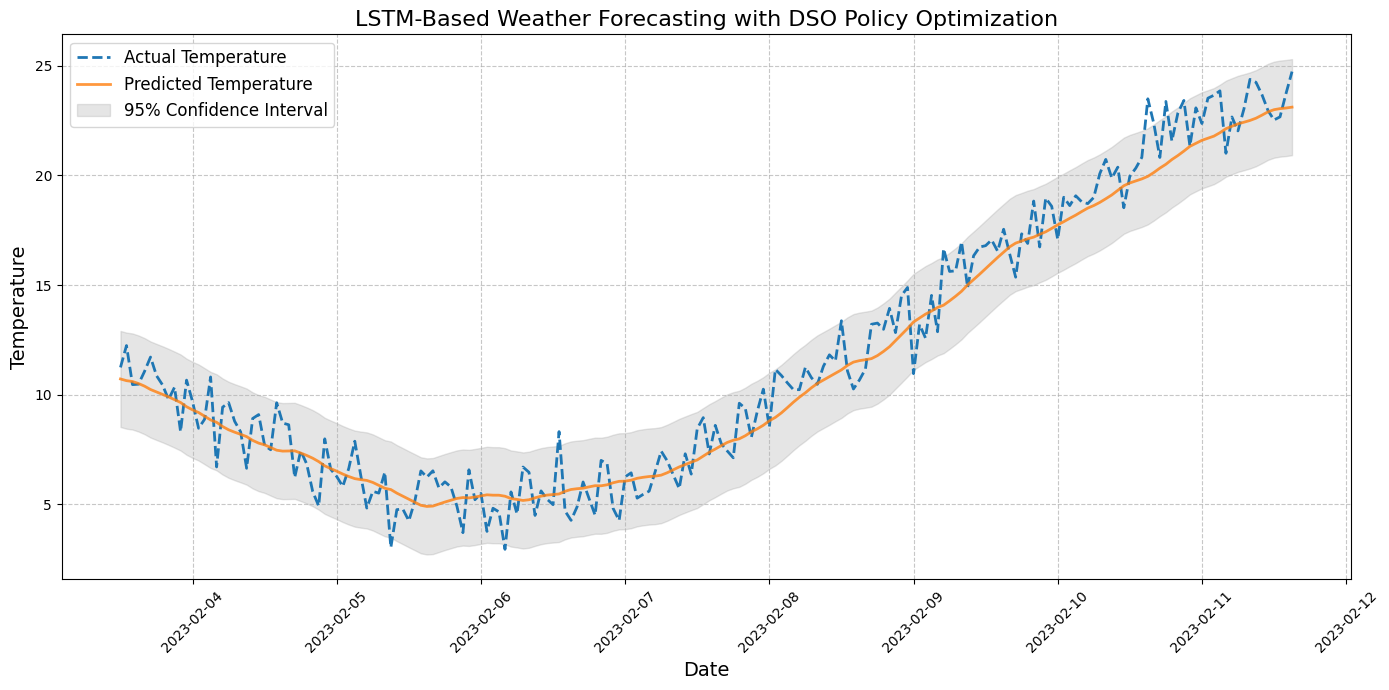

In [42]:
# Additional plot for prediction visualization
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test_actual, label="Actual Temperature", linestyle="dashed", linewidth=2)
plt.plot(df.index[-len(y_pred):], y_pred_actual, label="Predicted Temperature", alpha=0.8, linewidth=2)

# Add confidence interval (optional)
if len(y_pred_actual) > 10:  # Only if we have enough predictions
    std_dev = np.std(y_test_actual - y_pred_actual)
    plt.fill_between(df.index[-len(y_pred):], 
                     y_pred_actual - 1.96*std_dev, 
                     y_pred_actual + 1.96*std_dev, 
                     color='gray', alpha=0.2, label='95% Confidence Interval')

plt.title("LSTM-Based Weather Forecasting with DSO Policy Optimization", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# Print model performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 1.4025
Root Mean Squared Error (RMSE): 1.1843
Mean Absolute Error (MAE): 0.9721
R² Score: 0.9634


In [44]:
# Define In-Situ Constraints to Ensure Valid Symbolic Transformations
class InSituConstraints:
    def apply(self, expression):
        expr_str = str(expression)  # Convert symbolic expression to string for validation
        if 'sin(cos(' in expr_str or 'log(exp(' in expr_str:
            return False  # Prevent nested functions
        if len(expr_str.split()) < 4 or len(expr_str.split()) > 30:
            return False  # Ensure length constraints
        return True  # Valid expression

constraints = InSituConstraints()

In [23]:
# Apply Exploration Techniques: Hierarchical Entropy Regularization & Soft Length Prior
class ExplorationTechniques:
    def hierarchical_entropy_regularization(self, policy_distribution):
        # Convert tensor to numpy array safely if needed
        if isinstance(policy_distribution, tf.Tensor):
            policy_distribution = global_sess.run(policy_distribution)
        return policy_distribution * np.log(policy_distribution + 1e-8)  # Encourage exploration
    
    def soft_length_prior(self, policy_expression):
        return -0.1 * len(str(policy_expression))  # Penalize overly long expressions

exploration = ExplorationTechniques()

In [ ]:
# Import DSO packages
from dso.config import load_config
from dso.library import Library, Token
from dso.functions import create_tokens
from dso.task.regression.regression import RegressionTask
from dso.task.regression.dataset import BenchmarkDataset
from dso.task.regression.dataset_loaders import load_dataset 
from dso.policy.policy import make_policy
from dso.policy_optimizer import make_policy_optimizer
from dso.train import Trainer

# Setup DSO configuration - use the same global session
config = load_config()

# Load the dataset properly
X_train_dso, y_train_dso, X_test_dso, y_test_dso = load_dataset("Nguyen-7")

# Create a benchmark dataset with the loaded data
dataset = BenchmarkDataset(
    name="Nguyen-7",
    X_train=X_train_dso,
    y_train=y_train_dso,
    X_test=X_test_dso,
    y_test=y_test_dso
)

# Create task with the properly initialized dataset
task = RegressionTask(config, dataset)

# Create state manager
state_manager = tf.compat.v1.train.get_or_create_global_step()

# Create prior
prior = task.make_prior()

# Create policy and policy optimizer with the global session
policy = make_policy(global_sess, prior, state_manager, "rnn")
policy_optimizer = make_policy_optimizer(global_sess, policy, "pqt")

# Make sure all variables are initialized
global_sess.run(tf.compat.v1.global_variables_initializer())

# Train policy optimizer using learned LSTM model
trainer = Trainer(
    sess=global_sess,  # Use the same global session
    policy=policy, 
    policy_optimizer=policy_optimizer, 
    gp_controller=None, 
    logger=None,
    pool=None, 
    n_samples=100000, 
    batch_size=1000, 
    alpha=0.5, 
    epsilon=0.05, 
    verbose=True
)
trainer.train()

ModuleNotFoundError: No module named 'dso.task.regression.dataset_loaders'

In [60]:
# Feedback Loop: Use best policy for next generation
best_policy = policy

# Plot Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(df.index[-len(y_test):], y_test_actual[:, 0], label="Actual Temperature", linestyle="dashed")
plt.plot(df.index[-len(y_pred):], y_pred_actual[:, 0], label="Predicted Temperature", alpha=0.8)
plt.legend()
plt.title("LSTM-Based Weather Forecasting with DSO Policy Optimization")
plt.show()


NameError: name 'policy' is not defined